In [ ]:
!pip install seirsplus networkx==2.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.4 MB/s eta 0:00:00
  Created wheel for seirsplus: filename=seirsplus-1.0.9-py3-none-any.whl size=64616 sha256=4e07f1fc39037505c0ab8a9498a84522082db3901091a099aef896a37f2fd7c2
  Stored in directory: /root/.cache/pip/wheels/2e/15/4f/a76c590ab249db0a821d0bbe652e2bed3f5e6ecdd6f89b5d7e
Successfully built seirsplus
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
import networkx as nx
import random

def build_cruise_graph(n_passengers=3000, passengers_per_cabin=2, passenger_crew_ratio=2.5):
    """
    Set the high-level cruise occupant parameters to correspond to industry averages

    Graph below establishes connections based on:
      - Shared cabins between passengers
      - Shared decks between passengers
      - Shared dinner table between passengers
      - Crew-to-passenger interactions
      - Shared cabins between crew
      - Shared workspaces between crew

    The weights are based on my take on interaction frequency - happy to tweak as necessary

    Layers to add (optional)"
      - Age demographics (will increase complication for other elements of the simulation)
    """

    G = nx.Graph()

    n_crew = int(n_passengers / passenger_crew_ratio)
    total_nodes = n_passengers + n_crew

    G.add_nodes_from(range(total_nodes))

    # Adding labels for each passenger
    for i in range(n_passengers):
        G.nodes[i]['type'] = 'passenger'
        G.nodes[i]['id'] = i
        G.nodes[i]['cabin_id'] = i // passengers_per_cabin

    # Adding labels and categories for each crew member
    for i in range(n_passengers, total_nodes):
        crew_id = i
        crew_type = 'passenger_service' if i < n_passengers + int(0.7 * n_crew) else 'non_service'

        G.nodes[i]['type'] = 'crew'
        G.nodes[i]['crew_type'] = crew_type
        G.nodes[i]['id'] = crew_id

    # Creating function to default to max edge weight for overlapping connections
    def add_edge_max_weight(G, u, v, weight):
        if G.has_edge(u, v):
            G[u][v]['weight'] = max(G[u][v]['weight'], weight)
        else:
            G.add_edge(u, v, weight=weight)

    # Pairing two passengers in each cabin
    for i in range (0, n_passengers, passengers_per_cabin):
        cabin = list(range(i, min(i + passengers_per_cabin, n_passengers)))
        for u in cabin:
            for v in cabin:
                if u != v:
                    add_edge_max_weight(G, u, v, 1.0)

    # Creating the dining cohorts
    n_cohorts = 3
    cohort_size = n_passengers // n_cohorts

    for cohort_num in range(n_cohorts):
        start = cohort_num * cohort_size
        end = (cohort_num + 1) * cohort_size if cohort_num < n_cohorts - 1 else n_passengers
        cohort_passengers = list(range(start, end))

        # Creating tables of 8 passengers each, randomly assigned
        random.shuffle(cohort_passengers)

        for i in range(0, len(cohort_passengers), 8):
            table = cohort_passengers[i:i+8]
            for u in table:
                for v in table:
                    if u != v:
                        add_edge_max_weight(G, u, v, 0.7)

    # Creating deck-level groups for moderate interaction
    n_decks = 10

    passengers_per_deck = n_passengers // n_decks
    for i in range(n_passengers):
        G.nodes[i]['deck'] = i // passengers_per_deck

    for deck_num in range(n_decks):
        deck_passengers = [i for i in range(n_passengers) if G.nodes[i]['deck'] == deck_num]

        random.shuffle(deck_passengers)

        for i in range(len(deck_passengers)):
            u = deck_passengers[i]
            for _ in range(10):
                v = random.choice(deck_passengers)
                if u != v:
                    add_edge_max_weight(G, u, v, 0.2)

    # Creating transient connections between passengers across the whole ship
    for i in range(n_passengers):
        contacts = random.sample(range(n_passengers), 25)
        for j in contacts:
            if i != j:
                add_edge_max_weight(G, i, j, 0.1)

    # Connecting passenger_service crew to passengers
    for i in range(n_passengers, total_nodes):
        if G.nodes[i]['crew_type'] == 'passenger_service':
            served_passengers = random.sample(range(n_passengers), 50)
            for p in served_passengers:
                add_edge_max_weight(G, i, p, 0.3)

    # Adding weak connection between non-service crew and passengers
    for i in range(n_passengers, total_nodes):
          if G.nodes[i]['crew_type'] == 'non_service':
              served_passengers = random.sample(range(n_passengers), 10)
              for p in served_passengers:
                  add_edge_max_weight(G, i, p, 0.05)

    # Adding crew-to-crew edges (cabinmates and shared category)
    crew_ids = list(range(n_passengers, total_nodes))

    for i in range(0, len(crew_ids), 2):
        cabin = crew_ids[i:i+2]
        for u in cabin:
            for v in cabin:
                if u != v:
                    add_edge_max_weight(G, u, v, 1.0)

    service_crew = [i for i in crew_ids if G.nodes[i]['crew_type'] == 'passenger_service']
    non_service_crew = [i for i in crew_ids if G.nodes[i]['crew_type'] == 'non_service']

    for crew_group in [service_crew, non_service_crew]:
        for u in crew_group:
            peers = random.sample(crew_group, 30)
            for v in peers:
                if u != v:
                    add_edge_max_weight(G, u, v, 0.5)

    return G, n_passengers

def build_quarantine_graph(G, n_passengers):
    """
    This subgraph basically shuts down connections and confines people to cabins

    There's also some crew-to-crew interaction to keep the ship running
    """

    G_Q = nx.Graph()
    G_Q.add_nodes_from(G.nodes(data=True))

    total_nodes = len(G.nodes)

    for u in G_Q.nodes():
        u_type = G_Q.nodes[u]['type']

        if u_type == 'passenger':
            cabin_id = G_Q.nodes[u]['cabin_id']
            cabinmates = [v for v in range(n_passengers)
                          if v != u and G.nodes[v]['cabin_id'] == cabin_id]

        elif u_type == 'crew':
            crew_index = u - n_passengers
            bunkmate_index = crew_index ^ 1
            bunkmate = n_passengers + bunkmate_index

            if bunkmate != u and bunkmate < total_nodes:
                cabinmates = [bunkmate]
            else:
                  cabinmates = []

        else:
            cabinmates = []

        for v in cabinmates:
            G_Q.add_edge(u, v, weight=1.0)

    crew_ids = range(n_passengers, total_nodes)
    service_crew = [i for i in crew_ids if G_Q.nodes[i]['crew_type'] == 'passenger_service']
    non_service_crew = [i for i in crew_ids if G_Q.nodes[i]['crew_type'] == 'non_service']

    def add_sparse_crew_connections(group, num_edges=100):
        attempts = 0
        while num_edges > 0 and attempts < 5000:
            u, v = random.sample(group, 2)
            if not G_Q.has_edge(u, v):
                G_Q.add_edge(u, v, weight=0.2)
                num_edges -= 1
            attempts += 1

    add_sparse_crew_connections(service_crew, num_edges=50)
    add_sparse_crew_connections(non_service_crew, num_edges=20)

    return G_Q

In [ ]:
import numpy as np

G, n_passengers = build_cruise_graph()
G_Q = build_quarantine_graph(G, n_passengers)

assert G.number_of_nodes() == n_passengers + int(n_passengers/2.5)
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

degrees = np.array([d for _,d in G.degree()])
print("Mean degree:", degrees.mean())
print("Min/Max degree:", degrees.min(), "/", degrees.max())

comps = list(nx.connected_components(G))
print("# connected components:", len(comps))
print("Largest component (% of nodes):",
      len(comps[0]) / G.number_of_nodes())

weights = [d['weight'] for _,_,d in G.edges(data=True)]
print("Edge weights min/mean/max:", np.min(weights), np.mean(weights), np.max(weights))

cab0 = [v for v in G.neighbors(0)]
assert 1 in cab0, "Cabin‐mate edge missing"
print("Neighbors for passenger 0:", cab0[:5])

Nodes: 4200
Edges: 195787
Mean degree: 93.23190476190476
Min/Max degree: 54 / 128
# connected components: 1
Largest component (% of nodes): 1.0
Edge weights min/mean/max: 0.05 0.26979012906883504 1.0
Neighbors for passenger 0: [1, 14, 956, 264, 772]


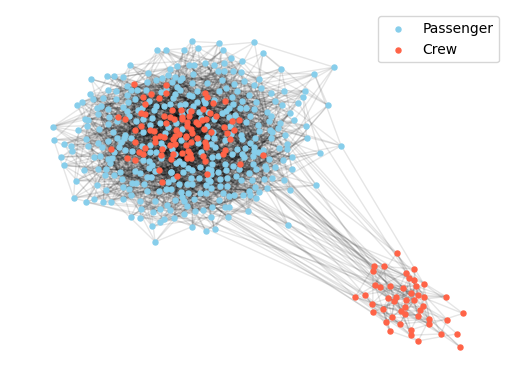

In [ ]:
import matplotlib.pyplot as plt

sample_nodes = random.sample(list(G.nodes()), 500)
H = G.subgraph(sample_nodes)

passengers = [n for n in H.nodes if G.nodes[n]['type'] == 'passenger']
crew = [n for n in H.nodes if G.nodes[n]['type'] == 'crew']

pos = nx.spring_layout(H, seed=42)
nx.draw_networkx_nodes(H, pos, nodelist=passengers, node_color='skyblue', label='Passenger', node_size=13)
nx.draw_networkx_nodes(H, pos, nodelist=crew, node_color='tomato', label='Crew', node_size=13)
nx.draw_networkx_edges(H, pos, alpha=0.1)
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
from seirsplus.models import SEIRSNetworkModel

SIGMA  = 1/5.2
GAMMA  = 1/10
MU_I   = 0.002

R0     = 2.5
BETA   = 1/(1/GAMMA) * R0
BETA_Q = 0.5*BETA

P      = 0.2
Q      = 0.05

In [ ]:
model = SEIRSNetworkModel(
    G       = G,
    beta    = BETA,
    sigma   = SIGMA,
    gamma   = GAMMA,
    mu_I    = MU_I,
    p       = P,
    G_Q     = G_Q,
    beta_Q  = BETA,
    sigma_Q = SIGMA,
    gamma_Q = GAMMA,
    mu_Q    = MU_I,
    q       = Q,
    initI   = 100,
    initE   = 0,
    initQ_E = 0,
    initQ_I = 0,
    initR   = 0,
    initF   = 0
)

/usr/local/lib/python3.11/dist-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


t = 0.04
t = 10.06
t = 20.00
t = 30.02
t = 40.03
t = 50.02
t = 60.05
t = 70.02
t = 80.01
t = 90.00
t = 100.01


/usr/local/lib/python3.11/dist-packages/seirsplus/models.py:1562: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


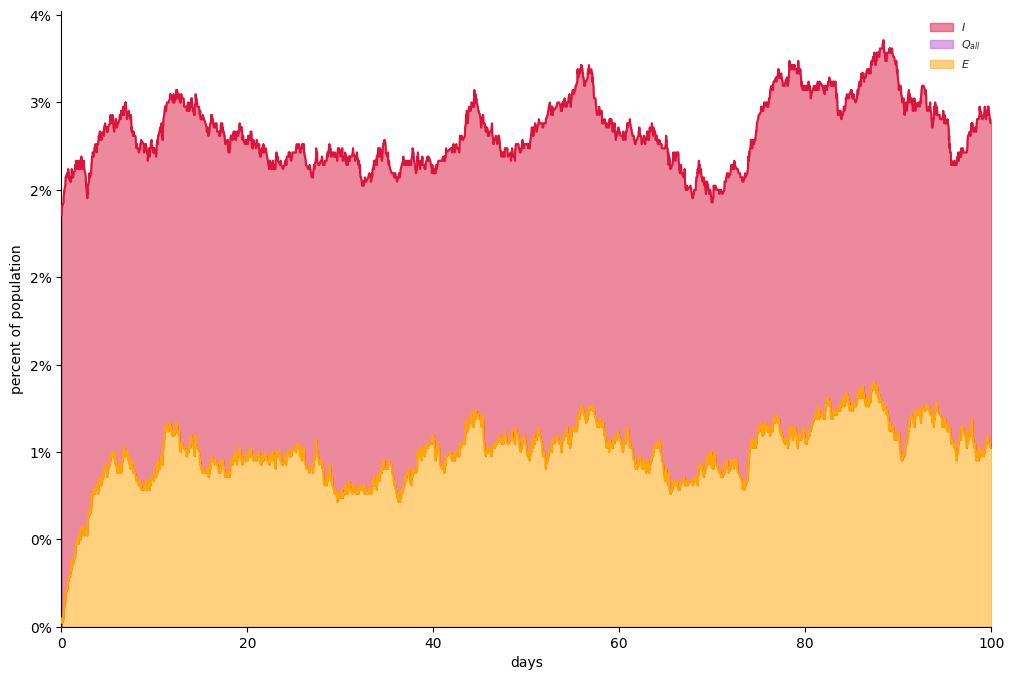

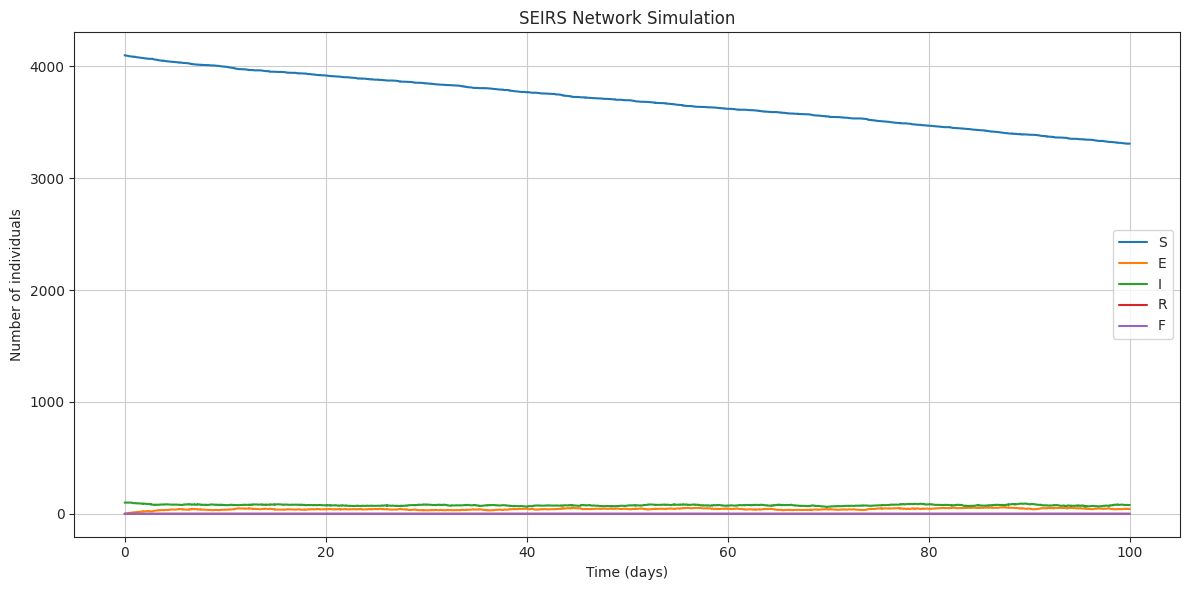

In [ ]:
model.run(T=100)
model.figure_infections()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(model.tseries, model.numS, label='S')
plt.plot(model.tseries, model.numE, label='E')
plt.plot(model.tseries, model.numI, label='I')
plt.plot(model.tseries, model.numR, label='R')
plt.plot(model.tseries, model.numF, label='F')

plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SEIRS Network Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

time = model.tseries
S = model.numS
E = model.numE
I = model.numI
R = model.numR
F = model.numF

df = pd.DataFrame({
    'Day'        : time,
    'Susceptible': S,
    'Exposed'    : E,
    'Infectious' : I,
    'Recovered'  : R,
    'Fatalities' : F
})

print(df)

       Day  Susceptible  Exposed  Infectious  Recovered  Fatalities
0      0.0       4100.0      0.0       100.0        0.0         0.0
1      0.0          0.0      0.0         0.0        0.0         0.0
2      0.0          0.0      0.0         0.0        0.0         0.0
3      0.0          0.0      0.0         0.0        0.0         0.0
4      0.0          0.0      0.0         0.0        0.0         0.0
...    ...          ...      ...         ...        ...         ...
25195  0.0          0.0      0.0         0.0        0.0         0.0
25196  0.0          0.0      0.0         0.0        0.0         0.0
25197  0.0          0.0      0.0         0.0        0.0         0.0
25198  0.0          0.0      0.0         0.0        0.0         0.0
25199  0.0          0.0      0.0         0.0        0.0         0.0

[25200 rows x 6 columns]
